# Helper Functions
## Converting images all to jpg

In [ ]:
from PIL import Image, UnidentifiedImageError
import os
import io
import glob
# import pyheif

directory = '/media/user/New Volume/TINKERMAN/OurDataset/PRS_CombinedDataset2/Train'

c=1
for filename in os.listdir(directory):

    try:
        # # In case files are in iphone AirDrop proprietary format (HEIC)
        # if filename.endswith(".heic") or filename.endswith(".HEIC"):
        #     heicfile = pyheif.read(os.path.join(img_dir,filename))
        #     image = Image.frombytes(
        #                 heicfile.mode, 
        #                 heicfile.size, 
        #                 heicfile.data,
        #                 "raw",
        #                 heicfile.mode,
        #                 heicfile.stride,
        #                 )
        #     name = 'img' + str(c) + '.jpg'
        #     image.save(os.path.join(img_dir, name))
        #     c+=1
        # else:
        im = Image.open(os.path.join(directory,filename))
        name=os.path.splitext(filename)[0] + '.jpg'
        rgb_im = im.convert('RGB')
        rgb_im.save(os.path.join(directory, name))
        c+=1
    except UnidentifiedImageError:
        print(f'Cannot find {filename} - Remove File')
        os.remove(os.path.join(directory,filename))
    except OSError as err:
        print(f'OSError {filename} - Remove File')
        os.remove(os.path.join(directory,filename))
    # print(os.path.join(directory, filename))

# Remove all non-jpg images inside the folder
for files in os.listdir(directory):
    if not files.endswith(".jpg"):
        os.remove(os.path.join(directory, files))
    else:
        continue

# Test Scripts for CLIP Clustering

In [ ]:
# Download packages - Skip if you already have
!conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
!pip install ftfy regex tqdm
!wget https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz -O bpe_simple_vocab_16e6.txt.gz
!pip install git+https://github.com/openai/CLIP.git

In [2]:
# Download CLIP model
import torch
import clip
from PIL import Image
import time
import matplotlib.pyplot as plt
import numpy as np
import pickle

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# NLP Preprocessing Functions

In [3]:
import gzip
import html
import os
from functools import lru_cache

import ftfy
import regex as re

@lru_cache()
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a corresponding list of unicode strings.
    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you want to avoid UNKs.
    When you're at something like a 10B token dataset you end up needing around 5K for decent coverage.
    This is a signficant percentage of your normal, say, 32K bpe vocab.
    To avoid that, we want lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code barfs on.
    """
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))


def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs


def basic_clean(text):
    text = ftfy.fix_text(text)
    text = html.unescape(html.unescape(text))
    return text.strip()


def whitespace_clean(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text


class SimpleTokenizer(object):
    def __init__(self, bpe_path: str = "bpe_simple_vocab_16e6.txt.gz"):
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        merges = gzip.open(bpe_path).read().decode("utf-8").split('\n')
        merges = merges[1:49152-256-2+1]
        merges = [tuple(merge.split()) for merge in merges]
        vocab = list(bytes_to_unicode().values())
        vocab = vocab + [v+'</w>' for v in vocab]
        for merge in merges:
            vocab.append(''.join(merge))
        vocab.extend(['<|startoftext|>', '<|endoftext|>'])
        self.encoder = dict(zip(vocab, range(len(vocab))))
        self.decoder = {v: k for k, v in self.encoder.items()}
        self.bpe_ranks = dict(zip(merges, range(len(merges))))
        self.cache = {'<|startoftext|>': '<|startoftext|>', '<|endoftext|>': '<|endoftext|>'}
        self.pat = re.compile(r"""<\|startoftext\|>|<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d|[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+""", re.IGNORECASE)

    def bpe(self, token):
        if token in self.cache:
            return self.cache[token]
        word = tuple(token[:-1]) + ( token[-1] + '</w>',)
        pairs = get_pairs(word)

        if not pairs:
            return token+'</w>'

        while True:
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = ' '.join(word)
        self.cache[token] = word
        return word

    def encode(self, text):
        bpe_tokens = []
        text = whitespace_clean(basic_clean(text)).lower()
        for token in re.findall(self.pat, text):
            token = ''.join(self.byte_encoder[b] for b in token.encode('utf-8'))
            bpe_tokens.extend(self.encoder[bpe_token] for bpe_token in self.bpe(token).split(' '))
        return bpe_tokens

    def decode(self, tokens):
        text = ''.join([self.decoder[token] for token in tokens])
        text = bytearray([self.byte_decoder[c] for c in text]).decode('utf-8', errors="replace").replace('</w>', ' ')
        return text

# Test Run Zero-Shot Classification on a single image

In [ ]:
img_filepath = '/media/user/New Volume/TINKERMAN/imagenet_Subset/val/ILSVRC2012_val_00000001.JPEG'

input_text = "This is an image of a dog"

image = preprocess(Image.open(img_filepath)).unsqueeze(0).to(device)

# Input Text for tokenisation
# text = clip.tokenize(["a green snake", "a serpent", "a green animal"]).to(device)
text = clip.tokenize(input_text).to(device)

with torch.no_grad():
    image_encode_time = time.time()
    image_features = model.encode_image(image)
    print(f'Image Encode Time: {time.time() - image_encode_time} secs')
    text_encode_time = time.time()
    text_features = model.encode_text(text)
    print(f'Text Encode Time: {time.time() - text_encode_time} secs')
    
    # This portion of code is to ndo prediction of images based on input text
    predict_time = time.time()
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    print(f'CLIP Predict Time: {time.time() - predict_time} secs')
    
# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
# similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
similarity = image_features.cpu().numpy() @ text_features.cpu().numpy().T
# values, indices = similarity[0].topk(5)

print(similarity)
# print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

# print(f'IMAGE_TENSOR: {image_features.T}')
# print(f'TEXT_TENSOR: {text_features.T}')

# Feature Extraction - Using CLIP to extract information
## Define the directory of images and process them sequentially
### - Normalise the image
### - Run forward pass of the model on image and text

In [47]:
image_set_features = torch.empty([0, 512], dtype=torch.float16).to(device)

images = []
img_filename = []

tensor_file_dir = "tensors/"
image_dir = '/media/user/New Volume/TINKERMAN/OurDataset/PRS_CombinedDataset2/train'
file_directory = [filename for filename in os.listdir(image_dir) if filename.endswith(".jpg")]
image_count = 0
# Bag the iamge size to limit processing the whole dataset - Can set this to full size if you want
# image_bag = 50
image_bag = len(file_directory)
print(f'No of Files: {image_bag}')

for filename in file_directory:
   
    # Retrieve File name
    name = filename.replace("/media/user/New Volume/TINKERMAN/OurDataset/PRS_CombinedDataset2/train\\", '', 1)
    img_filename.append(name)

    if image_count == image_bag:
        print(f'Reach end of sample size {image_bag}')
        break

    # image = preprocess(Image.open(os.path.join(image_dir, filename)).convert("RGB"))
    image = Image.open(os.path.join(image_dir, filename)).convert("RGB")
    images.append(image)
    
    # image_input = torch.stack([preprocess(img) for img in images]).to(device)
    image_input = preprocess(image).unsqueeze(0).to(device)

    # Perform image encoding
    with torch.no_grad():
        image_encode_time = time.time()
        image_features = model.encode_image(image_input)
        print(f'Image {image_count} Encode Time: {time.time() - image_encode_time} secs')
    
    # Normalisation Image Features
    image_features /= image_features.norm(dim=-1, keepdim=True)
    # Append image batch to list of features
    image_set_features = torch.cat((image_set_features, image_features))

    image_count += 1

# plt.tight_layout()
# image.close()

# Create tensor directory to store saved tensors
if not os.path.exists(tensor_file_dir):
    os.mkdir(tensor_file_dir)

# Save pytorch image tensors here
torch.save(image_set_features, os.path.join(tensor_file_dir, 'image_embeddings_OurDataset2.pt'))

No of Files: 2000
Image 0 Encode Time: 0.008620023727416992 secs
Image 1 Encode Time: 0.009507894515991211 secs
Image 2 Encode Time: 0.009796857833862305 secs
Image 3 Encode Time: 0.010601997375488281 secs
Image 4 Encode Time: 0.009511709213256836 secs
Image 5 Encode Time: 0.008557558059692383 secs
Image 6 Encode Time: 0.009752750396728516 secs
Image 7 Encode Time: 0.009186983108520508 secs
Image 8 Encode Time: 0.009563922882080078 secs
Image 9 Encode Time: 0.00921320915222168 secs
Image 10 Encode Time: 0.011706829071044922 secs
Image 11 Encode Time: 0.008826494216918945 secs
Image 12 Encode Time: 0.013369560241699219 secs
Image 13 Encode Time: 0.009963512420654297 secs
Image 14 Encode Time: 0.008620977401733398 secs
Image 15 Encode Time: 0.010094165802001953 secs
Image 16 Encode Time: 0.00850534439086914 secs
Image 17 Encode Time: 0.008642911911010742 secs
Image 18 Encode Time: 0.008248090744018555 secs
Image 19 Encode Time: 0.008540153503417969 secs
Image 20 Encode Time: 0.0097620487

# Dump image filename list into pickle for reference

In [28]:
import natsort
tensor_file_dir = "tensors/"
image_file_name_pickle = "image_filenames_OurDataset2.pkl"

open_file = open(os.path.join(tensor_file_dir, image_file_name_pickle), "wb")
pickle.dump(natsort.natsorted(img_filename),open_file)
# pickle.dump(img_filename, open_file)
open_file.close()

# Load Image Tensors and Perform Similarity Matching
## - Search by Text Prompts
## - Search by Image Similarities

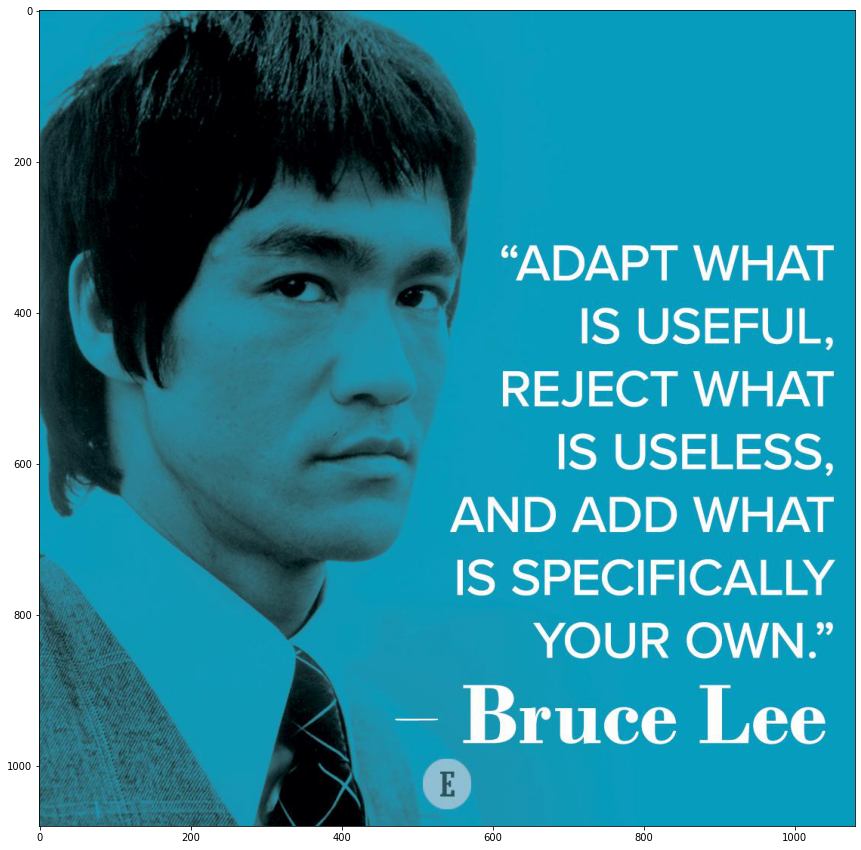

In [9]:
# Display Query Image
# Retrieve Test Image Query
imgSample_filepath = '/media/user/New Volume/TINKERMAN/OurDataset/PRS_CombinedDataset/train/14311265_10154545979703896_614300630827326582_o.jpg'
imageSample = Image.open(imgSample_filepath).convert("RGB")

plt.figure(figsize=(15, 15))
plt.imshow(imageSample)

In [32]:
import pickle
# File Directories
tensor_file_dir = "tensors/"
image_dir = '/media/user/New Volume/TINKERMAN/OurDataset/PRS_CombinedDataset2/train/'

# Extract filenames from pickle
image_file_name_pickle = "image_filenames_OurDataset2.pkl"
open_pickled_file = open(os.path.join(tensor_file_dir, image_file_name_pickle), "rb")
img_filename = pickle.load(open_pickled_file)
open_pickled_file.close()

In [11]:
# File Directories
tensor_file_dir = "tensors/"
image_dir = '/media/user/New Volume/TINKERMAN/OurDataset/PRS_CombinedDataset2/train/'

# Extract filenames from pickle
image_file_name_pickle = "image_filenames_OurDataset2.pkl"
open_pickled_file = open(os.path.join(tensor_file_dir, image_file_name_pickle), "rb")
img_filename = pickle.load(open_pickled_file)
open_pickled_file.close()

# Decide on Top_k Values
display_topK = 15

# Preprocess Sample Query
imageSample = preprocess(Image.open(imgSample_filepath)).unsqueeze(0).to(device)

image_tensor = torch.load(tensor_file_dir + 'image_embeddings_OurDataset2.pt')
image_results_list = []

# Perform Image and Text Encoding
with torch.no_grad():
    image_encode_time = time.time()
    image_features = model.encode_image(imageSample)
    print(f'Image Encode Time: {time.time() - image_encode_time} secs')

image_features /= image_features.norm(dim=-1, keepdim=True)

# Compute Similarities
similarities_images = image_tensor @ image_features.T
values_img, best_photo_idx_img = similarities_images.topk(display_topK, dim=0)

similar_image_names_images = []

for id in best_photo_idx_img:
    similar_image_names_images.append(img_filename[id])

# Set plot area size
ax1 = plt.figure(figsize=(20, 20))
ax1.suptitle('SIMILARITY - IMAGES', fontsize=16)
for image_list in range(len(similar_image_names_images)):
    print(os.path.join(image_dir, similar_image_names_images[image_list]))
    image_result = Image.open(os.path.join(image_dir, similar_image_names_images[image_list])).convert("RGB")
    image_results_list.append(image_result)
    
    plt.subplot(5, len(similar_image_names_images)/2, len(image_results_list))
    plt.imshow(image_result)
    plt.tight_layout()

image_result.close()

EOFError: Ran out of input

## Query by Text

Token Length: 7 - Tokens: [[589, 533, 320, 1674, 539, 4160, 3918]]
Text Encode Time: 0.008419513702392578 secs
/media/user/New Volume/TINKERMAN/OurDataset/PRS_CombinedDataset2/train/ODS00428.jpg
/media/user/New Volume/TINKERMAN/OurDataset/PRS_CombinedDataset2/train/ODS01195.jpg


<ipython-input-46-0d0ec2d1bc6a>:67: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(5, len(similar_image_names_images)/2, len(image_results_list))


/media/user/New Volume/TINKERMAN/OurDataset/PRS_CombinedDataset2/train/ODS00021.jpg
/media/user/New Volume/TINKERMAN/OurDataset/PRS_CombinedDataset2/train/ODS01778.jpg
/media/user/New Volume/TINKERMAN/OurDataset/PRS_CombinedDataset2/train/ODS00967.jpg
/media/user/New Volume/TINKERMAN/OurDataset/PRS_CombinedDataset2/train/ODS01203.jpg
/media/user/New Volume/TINKERMAN/OurDataset/PRS_CombinedDataset2/train/ODS01097.jpg
/media/user/New Volume/TINKERMAN/OurDataset/PRS_CombinedDataset2/train/ODS01893.jpg
/media/user/New Volume/TINKERMAN/OurDataset/PRS_CombinedDataset2/train/ODS01823.jpg
/media/user/New Volume/TINKERMAN/OurDataset/PRS_CombinedDataset2/train/ODS00939.jpg
/media/user/New Volume/TINKERMAN/OurDataset/PRS_CombinedDataset2/train/ODS01077.jpg
/media/user/New Volume/TINKERMAN/OurDataset/PRS_CombinedDataset2/train/ODS01921.jpg
/media/user/New Volume/TINKERMAN/OurDataset/PRS_CombinedDataset2/train/ODS01561.jpg
/media/user/New Volume/TINKERMAN/OurDataset/PRS_CombinedDataset2/train/ODS01

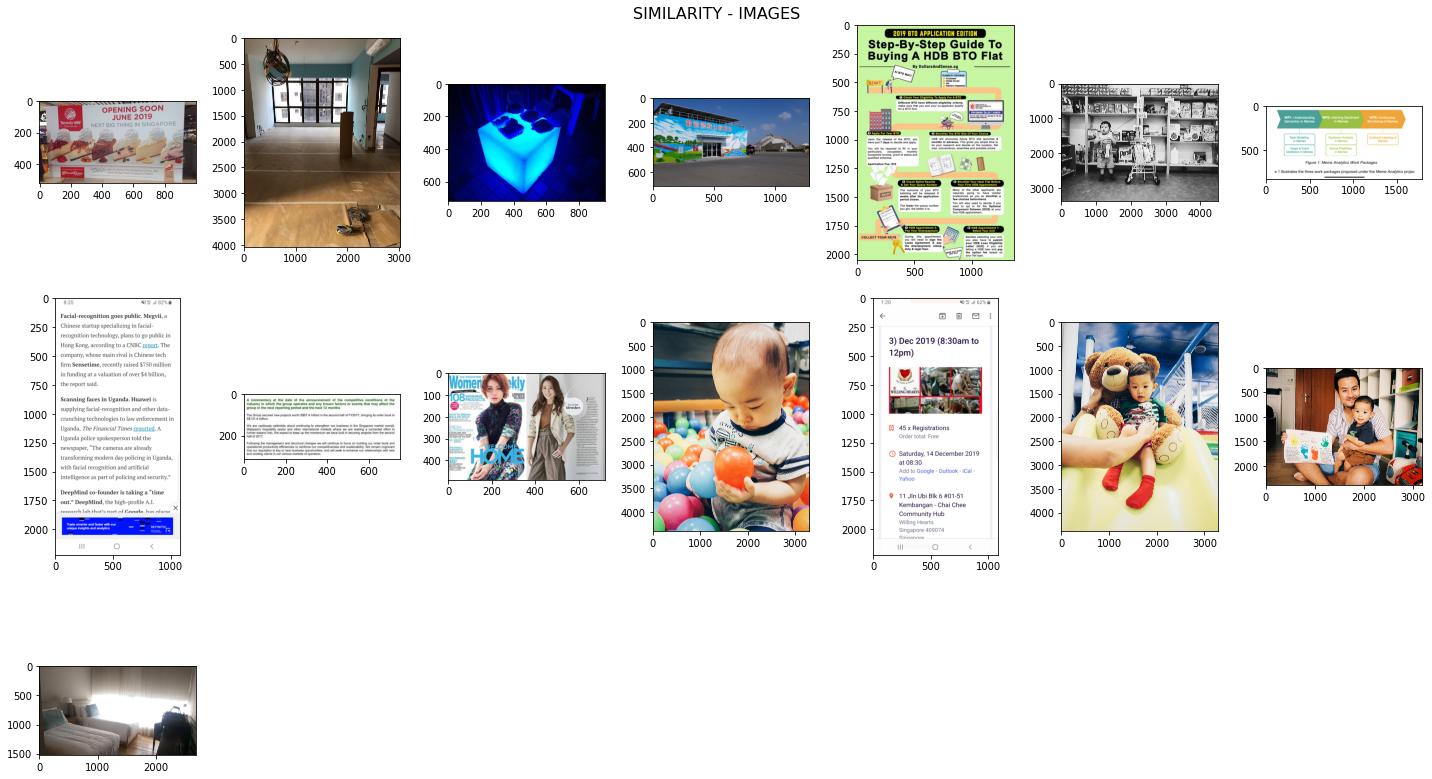

In [46]:
# Input Text Prompt
input_text = "text message"

# Text Pre-processing
# Append text-prompts for CLIP encoder in front
tokenizer = SimpleTokenizer()
text_tokens = [tokenizer.encode("This is a picture of " + input_text)]

print(f'Token Length: {len(text_tokens[0])} - Tokens: {text_tokens}')

# Handle abnormal inputs
# Check extracted text sentence length - CLIP tokeniser has a limit to text encoder. Need to find a way to work around this
# Check if return NULL
if len(text_tokens[0]) == 0:
    text_tokens = ['NULL']

if len(text_tokens[0]) > 70:
    text_tokens = [text_tokens[0][:70]]

# Define start and end stream
text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)
sot_token = tokenizer.encoder['<|startoftext|>']
eot_token = tokenizer.encoder['<|endoftext|>']

# Parse start and end Tags to input text
for i, tokens in enumerate(text_tokens):
    tokens = [sot_token] + tokens + [eot_token]
    text_input[i, :len(tokens)] = torch.tensor(tokens)

# Transfer to GPU to use CUDA
text_input = text_input.cuda()

# Perform Text encoding
with torch.no_grad():
    text_encode_time = time.time()
    text_features = model.encode_text(text_input)
    print(f'Text Encode Time: {time.time() - text_encode_time} secs')
    
# Normalisation Text Features
text_features /= text_features.norm(dim=-1, keepdim=True)

# Decide on Top_k Values
display_topK = 15

# Load Image Tensor Embeddings
image_tensor = torch.load(tensor_file_dir + 'image_embeddings_OurDataset2.pt')

image_results_list = []

# Compute Similarities
similarities_images = image_tensor @ text_features.T
values_img, best_photo_idx_img = similarities_images.topk(display_topK, dim=0)

similar_image_names_images = []

for id in best_photo_idx_img:
    similar_image_names_images.append(img_filename[id])

# Set plot area size
ax1 = plt.figure(figsize=(20, 20))
ax1.suptitle('SIMILARITY - IMAGES', fontsize=16)
for image_list in range(len(similar_image_names_images)):
    print(os.path.join(image_dir, similar_image_names_images[image_list]))
    image_result = Image.open(os.path.join(image_dir, similar_image_names_images[image_list])).convert("RGB")
    image_results_list.append(image_result)
    
    plt.subplot(5, len(similar_image_names_images)/2, len(image_results_list))
    plt.imshow(image_result)
    plt.tight_layout()

image_result.close()

# This Portion We Test Panoptic Segmentation with Detectron2 Framework

Detectron2 is a suite of CV models that enable image segmentation, Object Detection, Instance Segmentation etc.
## Link: https://github.com/facebookresearch/detectron2

In [ ]:
# Detectron2 Installation
!pip install pyyaml==5.1

# This is the current pytorch version on Colab. Uncomment this if Colab changes its pytorch version
# !pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html

# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html

In [ ]:
# check pytorch installation: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.9")   # please manually install torch 1.9 if Colab changes its default version

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import cv2

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
# Test Run Inference on a sample image
imgSample_filepath = '/media/user/New Volume/TINKERMAN/imagenet_Subset/val/ILSVRC2012_val_00000609.JPEG'
imageSample = Image.open(imgSample_filepath).convert("RGB")

# Get numpy image array matrix
img_rgb = np.array(imageSample)
# Flip colour channels
img_bgr = img_rgb[:, :, ::-1]

plt.figure(figsize=(15, 15))
plt.imshow(imageSample)

# Create a detectron2 config and a detectron2 DefaultPredictor to run inference on this image

## Instance Segmentation Config

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(img_bgr)

In [ ]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(img_bgr[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

image = out.get_image()
plt.figure(figsize=(15, 15))
plt.imshow(image)

## Panoptic Segmentation Config

In [ ]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)

# Run Inference
panoptic_seg, segments_info = predictor(img_bgr)["panoptic_seg"]
v = Visualizer(img_bgr[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)

thing_names = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes
stuff_names = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).stuff_classes

pred_class_names = []

# Visualise outpu
image = out.get_image()
plt.figure(figsize=(15, 15))
plt.imshow(image)

for objects in range(len(segments_info)):
    if segments_info[objects]['isthing'] == True:
        pred_class_names.append(thing_names[segments_info[objects]['category_id']])
    else:
        pred_class_names.append(stuff_names[segments_info[objects]['category_id']])

print(f'Detected Objects: {pred_class_names}')

## Run Panoptic Seg With Video
## Additional Code Base for reference

In [ ]:
# This is the video we're going to process
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("ll8TgCZ0plk", width=500)
display(video)

In [ ]:
# Install dependencies, download the video, and crop 5 seconds for processing
!pip install youtube-dl
!youtube-dl https://www.youtube.com/watch?v=ll8TgCZ0plk -f 22 -o video.mp4
!ffmpeg -i video.mp4 -t 00:00:06 -c:v copy video-clip.mp4

In [ ]:
# Run frame-by-frame inference demo on this video (takes 3-4 minutes) with the "demo.py" tool we provided in the repo.
!git clone https://github.com/facebookresearch/detectron2
# Note: this is currently BROKEN due to missing codec. See https://github.com/facebookresearch/detectron2/issues/2901 for workaround.
%run detectron2/demo/demo.py --config-file detectron2/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml --video-input video-clip.mp4 --confidence-threshold 0.6 --output video-output.mkv \
  --opts MODEL.WEIGHTS detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl

# Test out MDETR - Multimodal Detector Transformer
- VQA Task
- Referring Expressions
- Referring Segmentation

## Link: https://ashkamath.github.io/mdetr_page/

## Preliminaries
- Boilerplate section
- Install dependencies

In [ ]:
!pip install timm transformers

In [ ]:
import torch
import cv2
from PIL import Image
import requests
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from collections import defaultdict
import torch.nn.functional as F
import numpy as np
from skimage.measure import find_contours
import os
import MDETR.hubconf as hub

from matplotlib import patches,  lines
from matplotlib.patches import Polygon

# USE CUDA if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

torch.set_grad_enabled(False);
torch.cuda.empty_cache()

In [ ]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

## Define helper functions
- Colours
- Bounding Boxes

In [ ]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def plot_results(pil_img, scores, boxes, labels, answer, type_conf, ans_conf, masks=None):
    plt.figure(figsize=(12,12))
    np_image = np.array(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if masks is None:
      masks = [None for _ in range(len(scores))]
    assert len(scores) == len(boxes) == len(labels) == len(masks)
    for s, (xmin, ymin, xmax, ymax), l, mask, c in zip(scores, boxes.tolist(), labels, masks, colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{l}: {s:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15, bbox=dict(facecolor='white', alpha=0.8))

        if mask is None:
          continue
        np_image = apply_mask(np_image, mask, c)

        padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
          # Subtract the padding and flip (y, x) to (x, y)
          verts = np.fliplr(verts) - 1
          p = Polygon(verts, facecolor="none", edgecolor=c)
          ax.add_patch(p)

    plt.suptitle(f"Predicted answer: {answer} | confidence={round(100 * type_conf.item() * ans_conf.item(), 2)}", fontsize=16)
    plt.imshow(np_image)
    plt.axis('off')
    plt.show()

def display_frames(pil_img, scores, boxes, labels, masks=None):
    plt.figure(figsize=(16,10))
    np_image = np.array(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if masks is None:
      masks = [None for _ in range(len(scores))]
    assert len(scores) == len(boxes) == len(labels) == len(masks)
    for s, (xmin, ymin, xmax, ymax), l, mask, c in zip(scores, boxes.tolist(), labels, masks, colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{l}: {s:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15, bbox=dict(facecolor='white', alpha=0.8))

        if mask is None:
          continue
        np_image = apply_mask(np_image, mask, c)

        padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
          # Subtract the padding and flip (y, x) to (x, y)
          verts = np.fliplr(verts) - 1
          p = Polygon(verts, facecolor="none", edgecolor=c)
          ax.add_patch(p)

    plt.imshow(np_image)
    plt.axis('off')
    plt.show(block=False)
    plt.pause(0.01)
    plt.close()

def display_save_frames(pil_img, scores, boxes, labels,  path, iter, masks=None):
    plt.figure(figsize=(16,10))
    np_image = np.array(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if masks is None:
      masks = [None for _ in range(len(scores))]
    assert len(scores) == len(boxes) == len(labels) == len(masks)
    for s, (xmin, ymin, xmax, ymax), l, mask, c in zip(scores, boxes.tolist(), labels, masks, colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{l}: {s:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15, bbox=dict(facecolor='white', alpha=0.8))

        if mask is None:
          continue
        np_image = apply_mask(np_image, mask, c)

        padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
          # Subtract the padding and flip (y, x) to (x, y)
          verts = np.fliplr(verts) - 1
          p = Polygon(verts, facecolor="none", edgecolor=c)
          ax.add_patch(p)

    plt.imshow(np_image)
    plt.axis('off')

    # convert_image = cv2.cvtColor(np_image, cv2.COLOR_RGB2BGR)
    # Use plt.savefig to save images
    plt.savefig(os.path.join(path, 'img'+ str(iter) + '.jpg'), dpi=100, bbox_inches='tight', pad_inches = 0)
    plt.show(block=False)
    # plt.pause(0.01)
    plt.close()
    # cv2.imwrite(os.path.join(path, 'img'+ str(iter) + '.jpg'), convert_image) 

def add_res(results, ax, color='green'):
    #for tt in results.values():
    if True:
        bboxes = results['boxes']
        labels = results['labels']
        scores = results['scores']
        #keep = scores >= 0.0
        #bboxes = bboxes[keep].tolist()
        #labels = labels[keep].tolist()
        #scores = scores[keep].tolist()
    #print(torchvision.ops.box_iou(tt['boxes'].cpu().detach(), torch.as_tensor([[xmin, ymin, xmax, ymax]])))
    
    colors = ['purple', 'yellow', 'red', 'green', 'orange', 'pink']
    
    for i, (b, ll, ss) in enumerate(zip(bboxes, labels, scores)):
        ax.add_patch(plt.Rectangle((b[0], b[1]), b[2] - b[0], b[3] - b[1], fill=False, color=colors[i], linewidth=3))
        cls_name = ll if isinstance(ll,str) else CLASSES[ll]
        text = f'{cls_name}: {ss:.2f}'
        print(text)
        ax.text(b[0], b[1], text, fontsize=15, bbox=dict(facecolor='white', alpha=0.8))

# Visual Question & Answering
## Including Bounding Box Predictions

In [ ]:
# model_qa = torch.hub.load('ashkamath/mdetr:main', 'mdetr_efficientnetB5_gqa', pretrained=True, return_postprocessor=False)
model_qa, postprocessor = torch.hub.load('/home/user/Adriel/MTech-IS/GradCert_PatternRecognition/PRS_PractiseModule/MDETR', 'mdetr_resnet101_gqa', pretrained=True, return_postprocessor=True, source='local')
model_qa = model_qa.cuda()
model_qa.eval();

## Download the mapping from the answers to ID

In [ ]:
import json
answerMap_path = '/home/user/Adriel/MTech-IS/GradCert_PatternRecognition/PRS_PractiseModule/MDETR/pretrained_models/GQA_VisualQA/gqa_answer2id_by_type.json'
ans_json = open(answerMap_path)
answer2id_by_type = json.load(ans_json)
# answer2id_by_type = json.load(requests.get("https://nyu.box.com/shared/static/j4rnpo8ixn6v0iznno2pim6ffj3jyaj8.json", stream=True).raw)
id2answerbytype = {}                                                       
for ans_type in answer2id_by_type.keys():                        
    curr_reversed_dict = {v: k for k, v in answer2id_by_type[ans_type].items()}
    id2answerbytype[ans_type] = curr_reversed_dict                             

## Inference Function

In [ ]:
def plot_inference_qa(im, caption):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(im).unsqueeze(0).cuda()

  # propagate through the model
  memory_cache = model_qa(img, [caption], encode_and_save=True)
  outputs = model_qa(img, [caption], encode_and_save=False, memory_cache=memory_cache)

  # keep only predictions with 0.7+ confidence
  probas = 1 - outputs['pred_logits'].softmax(-1)[0, :, -1].cpu()
  keep = (probas > 0.7).cpu()

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'].cpu()[0, keep], im.size)

  # Extract the text spans predicted by each box
  positive_tokens = (outputs["pred_logits"].cpu()[0, keep].softmax(-1) > 0.1).nonzero().tolist()
  predicted_spans = defaultdict(str)
  for tok in positive_tokens:
    item, pos = tok
    if pos < 255:
        span = memory_cache["tokenized"].token_to_chars(0, pos)
        predicted_spans [item] += " " + caption[span.start:span.end]

  labels = [predicted_spans [k] for k in sorted(list(predicted_spans .keys()))]

  # Classify the question type
  type_conf, type_pred = outputs["pred_answer_type"].softmax(-1).max(-1)
  ans_type = type_pred.item()
  types = ["obj", "attr", "rel", "global", "cat"]

  ans_conf, ans = outputs[f"pred_answer_{types[ans_type]}"][0].softmax(-1).max(-1)
  answer = id2answerbytype[f"answer_{types[ans_type]}"][ans.item()]
  # print(f"Predicted answer: {answer} | confidence={round(100 * type_conf.item() * ans_conf.item(), 2)}")
  plot_results(im, probas[keep], bboxes_scaled, labels, answer, type_conf, ans_conf)

In [ ]:
plot_inference_qa(imageSample, "Where is the whale in the picture?")